In [3]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import collections
import quandl
import settings
quandl.ApiConfig.api_key = settings.api_key

In [4]:
btcusd = quandl.get("BITFINEX/ETHUSD", returns="numpy")
dates = [col[0] for col in btcusd]
prices = [col[3] for col in btcusd]
volumes = [col[7] for col in btcusd]

In [5]:
def movingAve(dates,prices,volumes,length):
    ave = collections.OrderedDict()
    for current in range(length, len(dates)):
        totSum = 0
        totVol = 0
        for ind in range(0,length):
            totSum += prices[current - ind] * volumes[current - ind]
            totVol += volumes[current - ind]
        ave[dates[current]] = totSum / totVol
    return ave

In [6]:
def MACD(dates,prices,volumes,short,long, normalize=True, smooth=False):
    shortMA = movingAve(dates,prices,volumes,short)
    longMA = movingAve(dates,prices,volumes,long)
    MACD = collections.OrderedDict()
    for current in range(long,len(dates)):
        MACD[dates[current]] = shortMA[dates[current]] - longMA[dates[current]]
        if(normalize): MACD[dates[current]] /= longMA[dates[current]]
    return MACD

In [48]:
def crossovers(dates,prices,volumes,short,long):
    div = MACD(dates,prices,volumes,short,long)
    cash = 1
    cashes = collections.OrderedDict()
    paid = False
    for current in range(long,len(dates)):
        cashes[dates[current]] = cash 
        if( not paid and 0 < div[dates[current]] ): paid = prices[current]
        if( paid and 0 > div[dates[current]]):
            cash = cash * prices[current] / paid
            paid = False
    return cashes

In [69]:
def shortLongHeat(shortlen,longlen,delta):
    highCash = 0
    highShort = 0
    highLong = 0
    totals = numpy.full((shortlen,longlen),1)
    for short in range(delta,shortlen):
        for long in range(short + delta, longlen):
            cashes = crossovers(dates,prices,volumes,short,long)
            totals[short, long] = cashes[dates[len(dates)-1]]
            if( highCash < cashes[dates[len(dates)-1]] ):
                highCash = cashes[dates[len(dates)-1]]
                highShort = short
                highLong = long
    return [highShort,highLong,highCash,totals]

In [83]:
heat = shortLongHeat(60,90,2)
totals = heat[3]
print 'Max:' + str(heat[2]) + 'X @ ' + str(heat[0]) + ' : ' + str(heat[1])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


Max:67.1318459907X @ 7 : 33


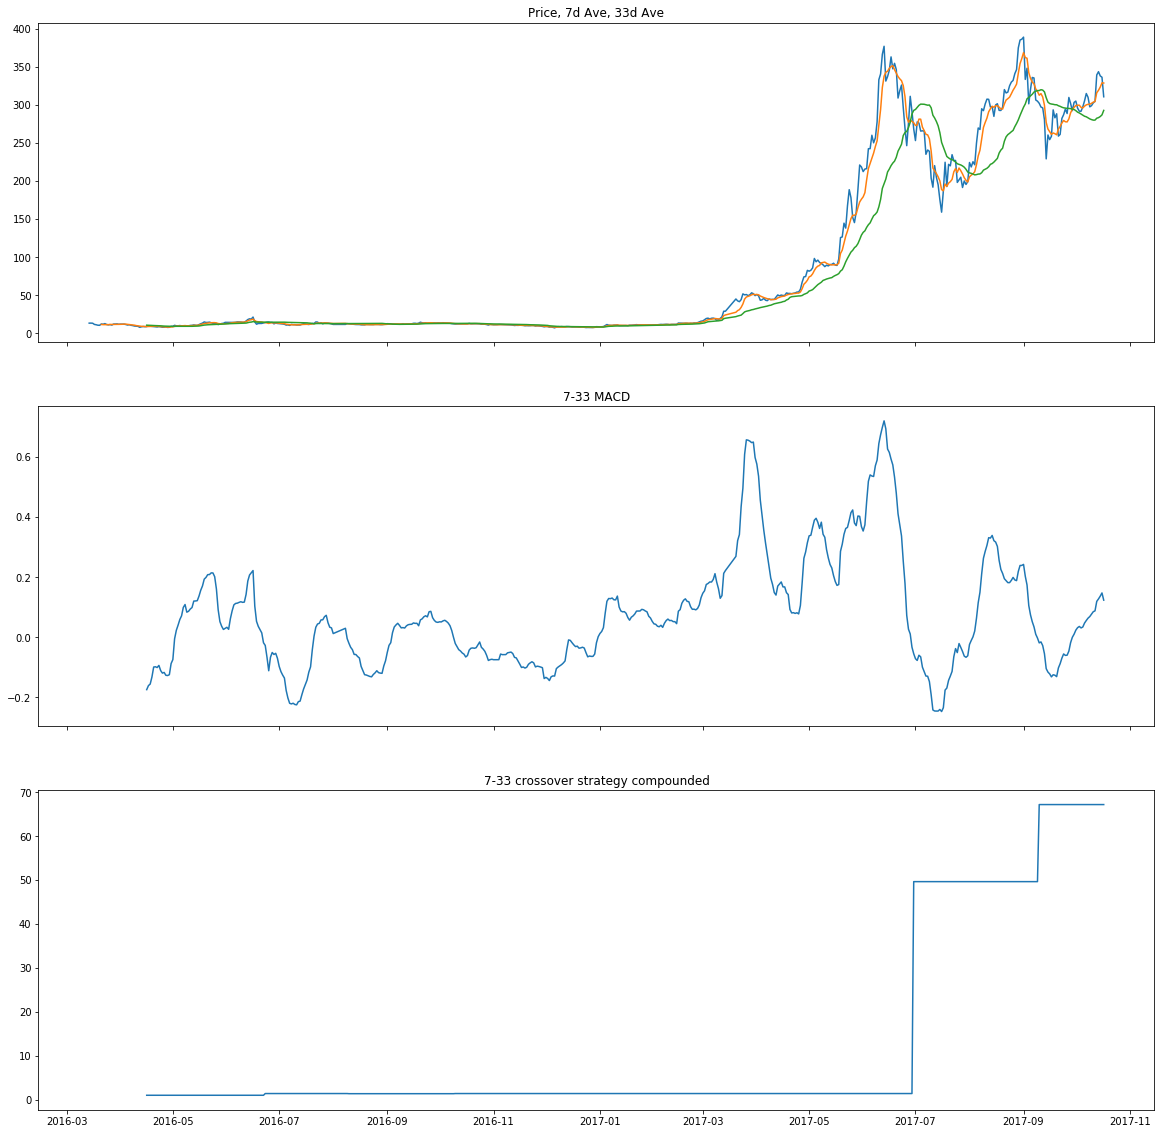

In [71]:
f, axarr = plt.subplots(3, sharex=True, figsize=(20,20))

# Price, short Ave, long Ave
axarr[0].plot(dates,prices)
ave = movingAve(dates,prices,volumes,heat[0])
axarr[0].plot(list(ave.keys()),list(ave.values()))
ave = movingAve(dates,prices,volumes,heat[1])
axarr[0].plot(list(ave.keys()),list(ave.values()))
axarr[0].set_title('Price, ' + str(heat[0]) + 'd Ave, ' + str(heat[1]) + 'd Ave');

# short-long MACD normalized by price
div = MACD(dates,prices,volumes,highShort,highLong)
axarr[1].plot(list(div.keys()),list(div.values()))
axarr[1].set_title(str(heat[0]) + '-' + str(heat[1]) + ' MACD' )

# Compounded returns on crossovers
cashes = crossovers(dates,prices,volumes,highShort,highLong)
axarr[2].plot(list(cashes.keys()),list(cashes.values()))
axarr[2].set_title(str(heat[0]) + '-' + str(heat[1]) + ' crossover strategy compounded')

plt.show()

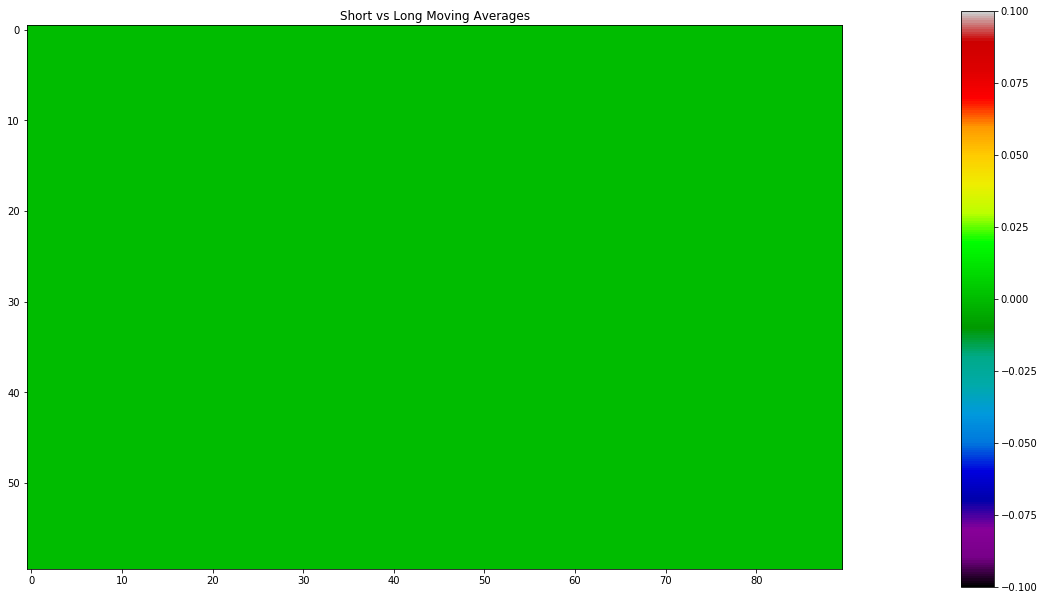

In [86]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(111)
ax.set_title('Short vs Long Moving Averages')

graphtotals = heat[3]
for i in range(60):
    for j in range(90):
        graphtotals[i][j] = numpy.log1p(heat[3][i][j])
imgplot = plt.imshow(graphtotals)
imgplot.set_cmap('nipy_spectral')
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8]) 
plt.colorbar(orientation='vertical', cax = cbaxes)
plt.show()

In [15]:
from poloniex import Poloniex
import time
polo = Poloniex()


print polo.returnChartData(currencyPair='BTC_ETH',period=900,start=(time.time()-90000),end=time.time())

[{u'volume': u'32.05200154', u'quoteVolume': u'550.01982386', u'high': u'0.0585712', u'low': u'0.05810002', u'date': 1508204700, u'close': u'0.05842', u'weightedAverage': u'0.05827426', u'open': u'0.05821892'}, {u'volume': u'35.40029678', u'quoteVolume': u'607.4452099', u'high': u'0.05854299', u'low': u'0.0581356', u'date': 1508205600, u'close': u'0.05828901', u'weightedAverage': u'0.05827734', u'open': u'0.05842'}, {u'volume': u'16.57741027', u'quoteVolume': u'284.89827403', u'high': u'0.05836143', u'low': u'0.058', u'date': 1508206500, u'close': u'0.05828149', u'weightedAverage': u'0.05818712', u'open': u'0.05828901'}, {u'volume': u'25.35044401', u'quoteVolume': u'436.23280296', u'high': u'0.05833462', u'low': u'0.05800151', u'date': 1508207400, u'close': u'0.05810538', u'weightedAverage': u'0.05811219', u'open': u'0.05805352'}, {u'volume': u'24.02993122', u'quoteVolume': u'413.56684796', u'high': u'0.05833089', u'low': u'0.05800001', u'date': 1508208300, u'close': u'0.05816137', u'w